# Appendix: code

In [29]:
import pandas as pd
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.manifold import MDS

Load the data and leave it ready to work. The dataset was taken from Kaggle, https://www.kaggle.com/nikitagrec/world-capitals-gps.

In [41]:
# Load csv and rename colums
df = pd.read_csv("data.csv")
df.rename(columns={"CountryName": "Country", "CapitalName": "capital", "CapitalLatitude": "lat", "CapitalLongitude": "lon", "CountryCode": "code", "ContinentName": "continent"}, inplace=True)
# Drop na values
df = df.dropna()
# Take 100 samples
# df = df.sample(n=100, random_state = 100)
df = df.reset_index(drop=True)
# Take the capitals, its latitud and longitd and some indices for toy example
cap = df[['capital','continent', 'Country']].copy()
val = df[['lat','lon']].copy().values
ind = cap.index[(cap['Country']=='Sweden') |(cap['Country']=='Greece') |(cap['Country']=='United Kingdom') |(cap['Country']=='Finland') |(cap['Country']=='Germany') | (cap['Country']=='Spain') | (cap['Country']=='Italy')| (cap['Country']=='France')| (cap['Country']=='Belgium') ].tolist()

Obtain the distance matrix from the latitud and longitud of every country

In [42]:
import geopy.distance
D = np.zeros((val.shape[0],val.shape[0]))
for i in range(val.shape[0]):
    for j in range(i+1,val.shape[0]):
        d = geopy.distance.geodesic((val[i,0], val[i,1]), (val[j,0], val[j,1]))
        distance = (d.km)**2
        D[i,j] = distance
        D[j,i] = distance

# Classic MDS

Copmute the similarity matrix and calculate its EVD. From that, we can get the projection matrix

In [43]:
# Compute similarity matrix
shape = D.shape
n = shape[0]
ones = np.ones((n,1))
J = ones.dot(ones.T)
centering = np.identity(n)-(1/n)*J
S = -(1/2)*centering.dot(D).dot(centering)

# Calculate EVD
l, u = np.linalg.eig(S)
subset = 2
X = np.diag(np.sqrt(l[:subset])).dot(u.T[:subset])

# Make sure the eigenvalues are greater than 0
indices = np.where(l[:subset]<0)
print(indices)

(array([], dtype=int64),)


# Metric MDS

I will use the sklearn library sklearn.manifold.
There are several parameters that can be tuned: 
* n_init. Number of times the SMACOF algorithm will be run with different initializations. The final results will be the best output of the runs, determined by the run with the smallest final stress
* max_iter. Maximum number of iterations of the SMACOF algorithm for a single run.
* eps. Relative tolerance with respect to stress at which to declare convergence.
* n_components. The number of components to select. In this case we are interested in two components

There are some parameters that could be tuned, such as the weights in the stress function, but in this library it's not possible to tune it.

The SMACOF (Scaling by MAjorizing a COmplicated Function) algorithm is a multidimensional scaling algorithm which minimizes an objective function (the stress) using a majorization technique. Stress majorization, also known as the Guttman Transform, guarantees a monotone convergence of stress, and is more powerful than traditional techniques such as gradient descent. (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.smacof.html)

In [44]:
# Copmute the matrix with coordinates X_metric
mds = MDS(dissimilarity='precomputed', n_components=2, random_state=1, n_init = 4, max_iter=300, eps=1e-3, n_jobs=-1)
X_metric = mds.fit_transform(np.sqrt(D))

## Tuning parameters

Tuning max_iter we can see that the algorithm converges in few iterations

In [7]:
max_iter=[*range(1, 50, 5)]
stress=[]
for i in max_iter:
    mds = MDS(dissimilarity='precomputed', random_state=1, n_init = 4, max_iter=i, eps=1e-3, n_jobs=-1)
    X_metric = mds.fit_transform(np.sqrt(D))
    stress.append(mds.stress_)

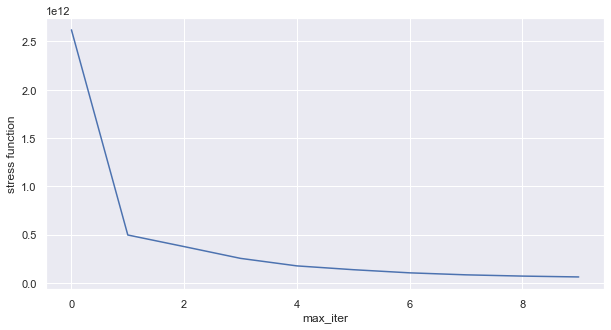

In [8]:
sns.set(rc={'figure.figsize':(10,5)})
plt.ylabel('stress function')
plt.xlabel('max_iter')
plt.plot(stress)

In [9]:
eps=[1,1e-3,1e-6]
stress=[]
for i in eps:
    mds = MDS(dissimilarity='precomputed', random_state=1, n_init = 4, max_iter=50, eps=i, n_jobs=-1)
    X_metric = mds.fit_transform(np.sqrt(D))
    stress.append(mds.stress_)
print(stress)

[57683666403.463875, 57683666403.463875, 57683666403.463875]


In [10]:
n_init=[1,4,20]
stress=[]
for i in n_init:
    mds = MDS(dissimilarity='precomputed', random_state=1, n_init = i, max_iter=50, eps=1e-3, n_jobs=-1)
    X_metric = mds.fit_transform(np.sqrt(D))
    stress.append(mds.stress_)
print(stress)

[178130236000.52002, 57683666403.463875, 57683666403.463875]


By changing the variable epsion or n_init the results don't seem to be different. Once the maximum number of iterations is large enough, the other two variables don't have a great influence. The final value of the set of parameters is: max_iter=50, eps=1e-3, n_init = 4.

# PLOTS

In [45]:
# Rotate the X matrix to suit the plot better
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return (X.dot(R)).T
X= rotate(X.T,70)

In [46]:
# Rotate it in the same way as with classic MDS
X_metric = X_metric.T
# X_metric= rotate(X_metric.T,45)

Classic MDS: Toy example with few european cities

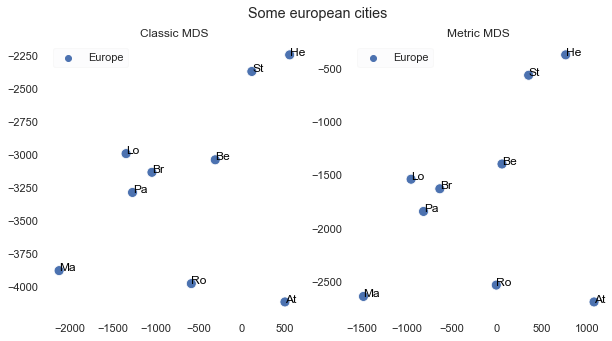

In [47]:
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(10,5)})
fig, axes = plt.subplots(ncols = 2)
fig.suptitle('Some european cities')

n_cap = cap[['capital']].values.flatten()[ind]
color = cap[['continent']].values.flatten()[ind]
y0 = -X[0,ind]
x0 = -X[1,ind]
x1 = +X_metric[0,ind]
y1 = +X_metric[1,ind]
ax0 = sns.scatterplot(x0,y0, hue = color, sizes = 50, s=100, ax=axes[0])
ax1 = sns.scatterplot(x1,y1, hue = color, sizes = 50, s=100, ax=axes[1])

ax0.set_title('Classic MDS')
ax1.set_title('Metric MDS')
ax0.legend(framealpha=0.1)
ax1.legend(framealpha=0.1)
ax0.grid(False)
ax0.set_facecolor('white')
ax1.grid(False)
ax1.set_facecolor('white')

for i, txt in enumerate(n_cap):
    ax0.text(x0[i]+1.5, y0[i], txt[0:2], size='medium', color='black', weight='light')
    ax1.text(x1[i]+1.5, y1[i], txt[0:2], size='medium', color='black', weight='light')

Plot of 100 cities around the world

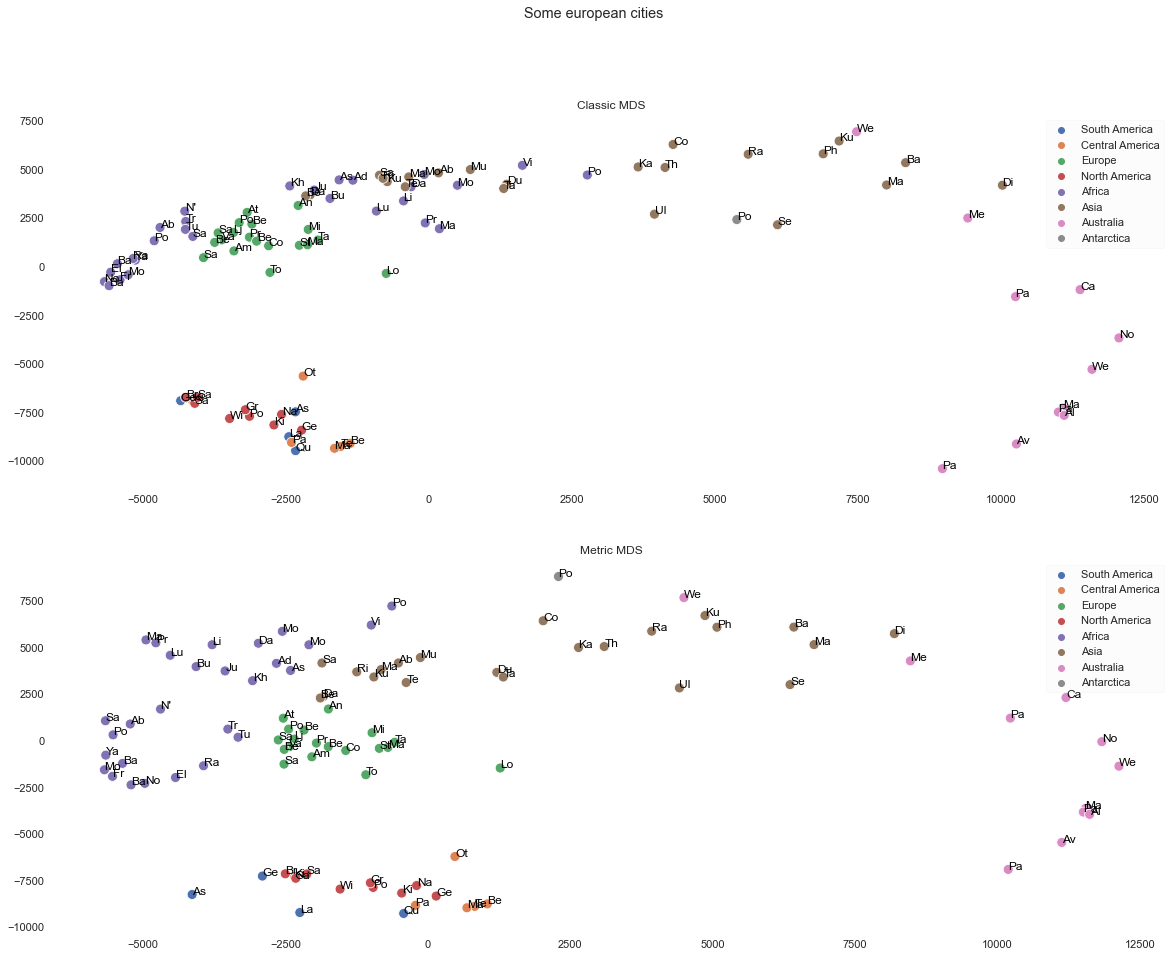

In [197]:
sns.set(rc={'figure.figsize':(20,15)})
fig, axes = plt.subplots(nrows = 2)
fig.suptitle('Some european cities')

n_cap = cap[['capital']].values.flatten()[:]
color = cap[['continent']].values.flatten()[:]
y0 = -X[0,:]
x0 = -X[1,:]
x1 = +X_metric[0,:]
y1 = +X_metric[1,:]
ax0 = sns.scatterplot(x0,y0, hue = color, sizes = 50, s=100, ax=axes[0])
ax1 = sns.scatterplot(x1,y1, hue = color, sizes = 50, s=100, ax=axes[1])

ax0.set_title('Classic MDS')
ax1.set_title('Metric MDS')
ax0.legend(framealpha=0.1)
ax1.legend(framealpha=0.1)
ax0.grid(False)
ax0.set_facecolor('white')
ax1.grid(False)
ax1.set_facecolor('white')

for i, txt in enumerate(n_cap):
    ax0.text(x0[i]+1.5, y0[i], txt[0:2], size='medium', color='black', weight='ultralight')
    ax1.text(x1[i]+1.5, y1[i], txt[0:2], size='medium', color='black', weight='ultralight')

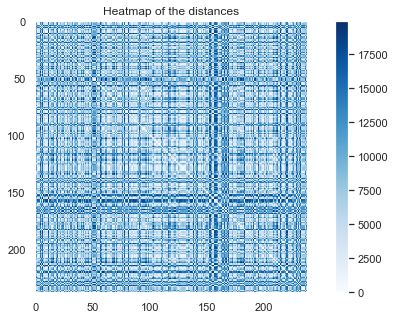

In [48]:
# Plot heatmap of the distance matrix D
plt.imshow(np.sqrt(D), zorder=2, cmap='Blues', interpolation='nearest')
plt.title('Heatmap of the distances')
plt.colorbar();

**Classical MDS:**

The results seem very good for Classical MDS, even thought not all the relative positions of the cities are the same. In the plot of some european cities the triangle Madrid, Rome, Paris seem to be a good enough representation. In the north, there are Helsinki and Stockholm, and also distances there seem to be respected. However, there are also some errors, such as the relative position of Rome and Athenes, given than Athenes is further south than Rome. Similar is the case of Berlin and London.

Looking at the representation of 238 cities from different continents,  we can take a look to the relation of Europe and Africa. Europe is above Africa, which is correct, but at some point some cities of Europe and Africa almost overlap, which should not be happening. The most visible example is in America, where North America, Central America and South America are a bit overlapped. At least we can see in a general view that in there's Europe, below Africa, on the left America, on the Right Asia and below Ocenania.

**Metric MDS:**

By comparing the example of the european cities, in both classic and metric MDS the results are really similar, except for Athenes. In metric MDS, Athenes, is further south than Rome, which makes sense and is a more truthful representation of relative positions. Therefore, in this case the results might be slightly better for metric MDS, even though both of them are almost identical. 
For the plot of all the cities, there are more differences. This time the difference between Europe, Africa and Asia is more visible, and there's no overlap among the three of them. Despite that, there is still overlap in America. I would conclude that metric MDS in this case is slightly better. 